In [15]:
import jax.numpy as jnp
from jax import vmap

from jaxgp.utils import CovMatrixDD, CovMatrixFD, CovMatrixFF
from jaxgp.kernels import RBF

## old

In [16]:
# x1 = jnp.zeros((5,1))
# x2 = jnp.zeros((5,2))
# x3 = jnp.zeros((5,3))
# x4 = jnp.zeros((5,4))

# params = jnp.array((1.0, 1.0))
# kernel = RBF()

In [17]:
# ff1d = CovMatrixFF(x1, x1, kernel,params)
# ff2d = CovMatrixFF(x2, x2, kernel,params)
# ff3d = CovMatrixFF(x3, x3, kernel,params)
# ff4d = CovMatrixFF(x4, x4, kernel,params)

# print(ff1d.shape, ff2d.shape, ff3d.shape, ff4d.shape)

In [18]:
# fd1d = CovMatrixFD(x1, x1, kernel,params)
# fd2d = CovMatrixFD(x2, x2, kernel,params)
# fd3d = CovMatrixFD(x3, x3, kernel,params)
# fd4d = CovMatrixFD(x4, x4, kernel,params)

# print(fd1d.shape, fd2d.shape, fd3d.shape, fd4d.shape)

# fd1d = vmap(jnp.ravel, in_axes=0)(CovMatrixFD(x1, x1, kernel,params))
# fd2d = vmap(jnp.ravel, in_axes=0)(CovMatrixFD(x2, x2, kernel,params))
# fd3d = vmap(jnp.ravel, in_axes=0)(CovMatrixFD(x3, x3, kernel,params))
# fd4d = vmap(jnp.ravel, in_axes=0)(CovMatrixFD(x4, x4, kernel,params))

# print(fd1d.shape, fd2d.shape, fd3d.shape, fd4d.shape)

In [19]:
# dd1d = CovMatrixDD(x1, x1, kernel,params)
# dd2d = CovMatrixDD(x2, x2, kernel,params)
# dd3d = CovMatrixDD(x3, x3, kernel,params)
# dd4d = CovMatrixDD(x4, x4, kernel,params)

# print(dd1d.shape, dd2d.shape, dd3d.shape, dd4d.shape)

# dd1d = jnp.hstack(jnp.hstack((*CovMatrixDD(x1, x1, kernel, params),)))
# dd2d = jnp.hstack(jnp.hstack((*CovMatrixDD(x2, x2, kernel, params),)))
# dd3d = jnp.hstack(jnp.hstack((*CovMatrixDD(x3, x3, kernel, params),)))
# dd4d = jnp.hstack(jnp.hstack((*CovMatrixDD(x4, x4, kernel, params),)))

# print(dd1d.shape, dd2d.shape, dd3d.shape, dd4d.shape)

## Creating the training data set

`jax.numpy` has almost the same usage as the standard `numpy` package, with the caveat that `jax.ndarray` is an immutable type, meaning that no inplace changes can be made. For creating training data this should however not be an issue.

In [20]:
import jax.numpy as jnp
from jax import random

We will model a simple sin function:

In [21]:
# true function is a noisy lennard jones potential
def sin(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.sin(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

def cos(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.cos(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

To define the training data we first need to define boundaries to choose the datapoints from. Then, random points are chosen in this interval. `random.split` creates a new subkey from the previous key to get a new sudo-random sample from the uniform distribution.

In [22]:
# Interval bounds from which to choose the data points
bounds = jnp.array([0.0, 2*jnp.pi])

# How many function and derivative observations should be chosen
num_f_vals = (1,)
num_d_vals = (3,)

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, num_f_vals, minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, num_d_vals, minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.1
key, subkey = random.split(key)
y_func = sin(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = cos(x_der, noise, subkey)

The GPR framework needs as input for training a tuple of arrays `X_split` of which contains a set of points where the function is sampled and a set of points where the gradient is sampled. Both array in `X_split` is of shape `(n_samples_i, N)`. `X_split` should be ordered as follows: the first array represents the datapoints for the function observations and the second array represents the gradient of the function. `Y_train` should just be an array of shape `(n_samples_function + n_samples_gradient,)`.

In [23]:
# reshaping needs to be done the get the arrays in the form (n_samples_i, N)
X_split = [x_func.reshape(-1,1),x_der.reshape(-1,1)]

Y_train = (y_func.reshape(-1,1), y_der.reshape(-1,1)) # jnp.hstack((y_func, y_der))

### Defining the Kernel and its initial parameters

The kernels can be found in `jaxgp.kernels`. Currently implemented are `RBF`, `Linear`, and `Periodic` kernels. When in doubt what kernel to use, go with an `RBF` kernel.

In [24]:
from jaxgp.kernels import RBF

kernel = RBF()
# an RBF kernel has per default 2 parameters
init_kernel_params = jnp.array([2.0, 2.0])

In [25]:
from jaxgp.regression import ExactGPR

model = ExactGPR(kernel, init_kernel_params, noise, "L-BFGS-B")
model.train(X_split, jnp.vstack(Y_train))

predict_grid = jnp.linspace(*bounds, 200)
means, stds = model.eval(predict_grid.reshape(-1,1))

OptStep(params=DeviceArray([0.7215639, 1.5752971], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(2.8434792, dtype=float32, weak_type=True), success=True, status=0, iter_num=6))


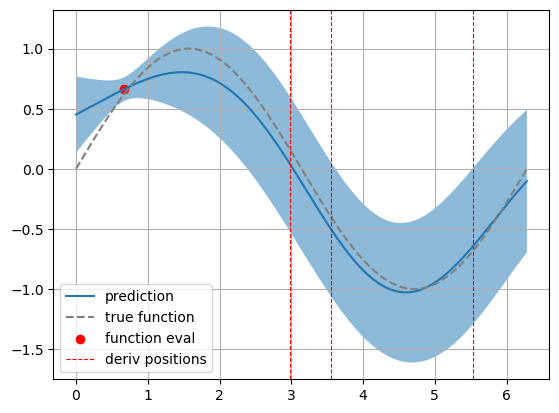

In [26]:
import matplotlib.pyplot as plt

means = means.reshape(-1)
stds = stds.reshape(-1)

plt.plot(predict_grid, means, label="prediction")
plt.fill_between(predict_grid, means-stds, means+stds, alpha=0.5)

plt.plot(predict_grid, sin(predict_grid), c="gray", ls="--",label="true function")

plt.scatter(x_func, y_func, c="r", label="function eval")
for i,x in enumerate(X_split[1]): 
    if i == 0:
        plt.axvline(x, c="r", lw=0.8, ls="--", label="deriv positions")
    else:
        plt.axvline(x, c="r", lw=0.8, ls="--")

plt.grid()
plt.legend()

In [27]:
from jaxgp.bayesopt import BayesOpt, maximum_confidence_grad

rand = 3
bounds = jnp.array([0.0,2*jnp.pi])
eval_func = lambda x: (cos(x, noise, key), True)
explore_param = 5
grid = jnp.linspace(0,2*jnp.pi,200)
extra_args = (grid.reshape(-1,1), eval_func)

model = BayesOpt(X_split, Y_train, kernel, init_kernel_params, noise, maximum_confidence_grad, extra_args)

In [28]:
model.run(10)

In [29]:
X_split = model.X_split
Y_train = jnp.vstack(model.Y_train)

In [30]:
from jaxgp.regression import ExactGPR

model = ExactGPR(kernel, init_kernel_params, noise, "L-BFGS-B")
model.train(X_split, Y_train)

predict_grid = jnp.linspace(*bounds, 200)
means, stds = model.eval(predict_grid.reshape(-1,1))

OptStep(params=DeviceArray([2.4237447, 2.283926 ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-2.4547844, dtype=float32, weak_type=True), success=True, status=0, iter_num=11))


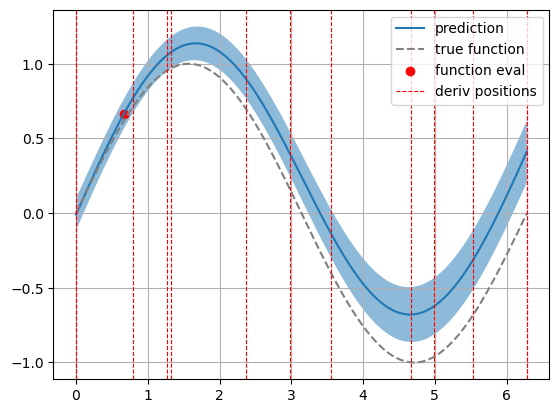

In [31]:
import matplotlib.pyplot as plt

means, stds = means.reshape(-1), stds.reshape(-1)

plt.plot(predict_grid, means, label="prediction")
plt.fill_between(predict_grid, means-stds, means+stds, alpha=0.5)

plt.plot(predict_grid, sin(predict_grid), c="gray", ls="--",label="true function")

plt.scatter(x_func, y_func, c="r", label="function eval")
for i,x in enumerate(X_split[1]): 
    if i == 0:
        plt.axvline(x, c="r", lw=0.8, ls="--", label="deriv positions")
    else:
        plt.axvline(x, c="r", lw=0.8, ls="--")

plt.grid()
plt.legend()

# no grad

In [32]:
X_train = x_func.reshape(-1,1)
Y_train = y_func

grid = jnp.linspace(0,2*jnp.pi,200)

In [33]:
from jaxgp.regression import ExactGPRnograd

In [34]:
model = ExactGPRnograd(kernel, init_kernel_params, noise)

In [35]:
model.train(X_train, Y_train)

OptStep(params=DeviceArray([0.43008026, 2.        ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(1.0085396, dtype=float32, weak_type=True), success=True, status=0, iter_num=6))


In [36]:
means, stds = model.eval(grid.reshape(-1,1))

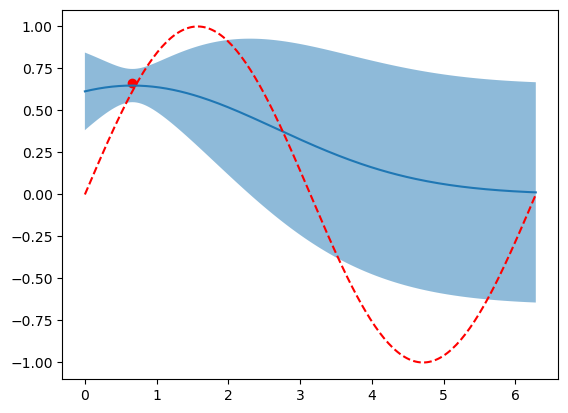

In [37]:
import matplotlib.pyplot as plt

plt.plot(grid, means)
plt.fill_between(grid, means-stds, means+stds, alpha=0.5)
plt.plot(grid, sin(grid), "r--")
plt.scatter(X_train, Y_train,c="r")